#### **Library imports**

In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Load dataset**

In [2]:
dataset = 'movielens'

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

n_users, n_items, n_samples_train, n_samples_test

(943, 1682, 159619, 40381)

#### **Defining collaborative filtering**

In [3]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        drop_u = nn.Dropout(p = 0.3)
        drop_i = nn.Dropout(p = 0.3)
        u = self.user_emb(user)
        i = self.item_emb(item)
        u = drop_u(u)
        i = drop_i(i)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

class GMF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.h = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        drop_u = nn.Dropout(p = 0.2)
        drop_i = nn.Dropout(p = 0.2)
        u = self.user_emb(user)
        i = self.item_emb(item)
        u = drop_u(u)
        i = drop_i(i)
        dot = (u * i)
        x = self.h(dot)
        return torch.sigmoid(x)

class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        swish = nn.SiLU()

        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.concat([u, i], dim = 1)
        x = swish(x)
        x = self.fc1(x)
        x = swish(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for surrogate meta-attack (surrogate-CF-SGD, evaluation-CF-Adam, same-init)**

In [10]:
# model settings
algorithm = 'meta'
surrogate = 'GMF'
target = 'GMF'
opt_surrogate = 'adam'
opt_target = 'adam'
lr_surrogate = 0.5
lr_target = 0.5
seed_surrogate = 20
seed_target = 50

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 1
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparameters
T = 20
Delta = 10000 # 5% ~ 10K perturbations for movielens
n_factors_surrogate = 16
n_factors_target = 16
save_results = True
retain_graph = True 
create_graph = False

if Delta < 100:
    save_results = False

# initialize list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []

perturbations['accuracy-before-surrogate'] = []
perturbations['accuracy-after-surrogate'] = []
perturbations['accuracy-unseen-surrogate'] = []

perturbations['loss-before-surrogate'] = []
perturbations['loss-after-surrogate'] = []
perturbations['loss-unseen-surrogate'] = []

perturbations['accuracy-before-target'] = []
perturbations['accuracy-after-target'] = []
perturbations['accuracy-unseen-target'] = []

perturbations['loss-before-target'] = []
perturbations['loss-after-target'] = []
perturbations['loss-unseen-target'] = []

perturbations['auc-before-surrogate'] = []
perturbations['auc-after-surrogate'] = []
perturbations['auc-unseen-surrogate'] = []

perturbations['auc-before-target'] = []
perturbations['auc-after-target'] = []
perturbations['auc-unseen-target'] = []

# print hyperparam configuration
print('-> Algorithm: ', algorithm)
print()
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples_train, 2)))
print('-> Embedding size (surrogate): ', n_factors_surrogate)
print('-> Embedding size (target): ', n_factors_target)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)
perturbs = torch.ones_like(ratings).bool()

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

if surrogate != 'CF':
    ratings = ratings.reshape((n_samples_train, 1))
    perturbs = perturbs.reshape((n_samples_train, 1))
    ratings_test = ratings_test.reshape((n_samples_test, 1))

# sample random negative edges to perturb
if 'base' in algorithm:
    edges = ratings.detach().to('cpu').numpy()
    neg_edges = np.where(edges == 0)[0]
    np.random.seed(0)
    edges_to_perturb = np.random.choice(neg_edges, size=Delta, replace = True) # sample Delta edges randomly and perturb one by one inside loop 

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define surrogate model and it's parameters
    if 'NCF' in surrogate:
        model = NCF(n_users, n_items, n_factors_surrogate)
    elif 'GMF' in surrogate:
        model = GMF(n_users, n_items, n_factors_surrogate)
    else:
        model = CollaborativeFiltering(n_users, n_items, n_factors_surrogate)
    model.to(device)

    # reset model paramters 
    torch.manual_seed(seed_surrogate)
    for layer in model.children():
        layer.reset_parameters()

    # define optimizer and loss function
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()
    model.eval()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy-before-surrogate'].append(get_accuracy(y_hat, ratings))
        perturbations['loss-before-surrogate'].append(loss_fn(y_hat, ratings).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-surrogate'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy-after-surrogate'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-surrogate'].append(loss_fn(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of surrogate model on unseen data
    with torch.no_grad():
        y_hat = model(users_test, items_test)
        perturbations['accuracy-unseen-surrogate'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-surrogate'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-surrogate'].append(roc_auc_score(y_actual, y_pred))

    # compute meta gradient
    if 'meta' in algorithm:
        meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    if 'NCF' in target:
        eval_model = NCF(n_users, n_items, n_factors_target)
    elif 'GMF' in target:
        eval_model = GMF(n_users, n_items, n_factors_target)
    else:
        eval_model = CollaborativeFiltering(n_users, n_items, n_factors_target)
    eval_model.to(device)

    # reset evaluation model parameters
    torch.manual_seed(seed_target)
    for layer in eval_model.children():
        layer.reset_parameters()

    # define optimizer and loss function for evaluation
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # reshape ratings and perturbs if necessary
    # later add code for reshaping ratings_test as well (incomplete right now)
    if surrogate != target:
        if 'NCF' in target:
            ratings_eval = ratings_eval.reshape((n_samples_train, 1))
            perturbs_eval = perturbs_eval.reshape((n_samples_train, 1))
        else:
            ratings_eval = ratings_eval.reshape((n_samples_train))
            perturbs_eval = perturbs_eval.reshape((n_samples_train))

    # inner train  evaluation model
    eval_model.train()
    for i in range(T):
        y_hat = eval_model(users, items)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items)
        perturbations['accuracy-before-target'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss-before-target'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # compute training AUROC including perturbed edges
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_eval.detach().clone().to('cpu').numpy() 
        perturbations['auc-before-target'].append(roc_auc_score(y_actual, y_pred))

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy-after-target'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss-after-target'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

        # compute training AUROC excluding perturbed edges
        y_pred = y_hat_masked.detach().clone().to('cpu').numpy()
        y_actual = ratings_masked.detach().clone().to('cpu').numpy()
        perturbations['auc-after-target'].append(roc_auc_score(y_actual, y_pred))

    # compute and store accuracy of target model on unseen data
    with torch.no_grad():
        y_hat = eval_model(users_test, items_test)
        perturbations['accuracy-unseen-target'].append(get_accuracy(y_hat, ratings_test))
        perturbations['loss-unseen-target'].append(loss_fn(y_hat, ratings_test).item())

        # compute unseen AUROC
        y_pred = y_hat.detach().clone().to('cpu').numpy()
        y_actual = ratings_test.detach().clone().to('cpu').numpy()
        perturbations['auc-unseen-target'].append(roc_auc_score(y_actual, y_pred))

    # select best edge and perform perturbation
    with torch.no_grad():
        if 'meta' in algorithm:
            mask = ratings.detach().int()
            meta_grad[mask == 1] = 0
            best_edge = meta_grad.argmax().item()
            ratings[best_edge] = 1
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(meta_grad[best_edge].item())

        else:
            best_edge = edges_to_perturb[delta]
            ratings[best_edge] = 1 
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(-1)

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# process results
perturbations = pd.DataFrame(perturbations)
filename = '{}({})-{}({})-{}-D={}-T={}-lr({},{})-seed({},{})'.format(surrogate, opt_surrogate, target, opt_target, algorithm, Delta, T, lr_surrogate, lr_target, seed_surrogate, seed_target)
print('-> File name: {}'.format(filename))
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')

-> Algorithm:  meta

-> T:  20
-> Delta: 10000 (6.26%)
-> Embedding size (surrogate):  16
-> Embedding size (target):  16
-> Device:  cuda:1

-> Surrogate:  GMF
-> Target:  GMF
-> Surrogate optimizer:  adam
-> Target optimizer:  adam
-> Surrogate learning rate:  0.5
-> Target learning rate:  0.5
-> Surrogate seed:  20
-> Target seed:  50

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 10000/10000 [49:43<00:00,  3.35it/s]


-> Execution time: 00h 49m 44s
-> File name: GMF(adam)-GMF(adam)-meta-D=10000-T=20-lr(0.5,0.5)-seed(20,50)


In [11]:
print('File name: ', filename)
if 'meta' in algorithm:
    print('Max meta-gradient: ', perturbations['metagrad'].max())
perturbations

File name:  GMF(adam)-GMF(adam)-meta-D=10000-T=20-lr(0.5,0.5)-seed(20,50)
Max meta-gradient:  0.0001674009981798008


,edges,metagrad,accuracy-before-surrogate,accuracy-after-surrogate,accuracy-unseen-surrogate,loss-before-surrogate,loss-after-surrogate,loss-unseen-surrogate,accuracy-before-target,accuracy-after-target,accuracy-unseen-target,loss-before-target,loss-after-target,loss-unseen-target,auc-before-surrogate,auc-after-surrogate,auc-unseen-surrogate,auc-before-target,auc-after-target,auc-unseen-target
0,82404,0.000167,0.817898,0.817898,0.776083,0.403261,0.403261,0.518691,0.824344,0.824344,0.780689,0.401228,0.401228,0.526672,0.901215,0.901215,0.855080,0.906038,0.906038,0.860518
1,136047,0.000165,0.818825,0.818830,0.776851,0.401577,0.401532,0.517609,0.822358,0.822363,0.779649,0.392443,0.392410,0.502264,0.902123,0.902133,0.855884,0.904862,0.904871,0.859757
2,57569,0.000157,0.819783,0.819794,0.777321,0.400468,0.400374,0.517379,0.822584,0.822594,0.779797,0.392324,0.392272,0.502594,0.902895,0.902916,0.856579,0.905037,0.905053,0.859936
3,82344,0.000152,0.820115,0.820125,0.777618,0.399614,0.399522,0.516260,0.820397,0.820413,0.777940,0.394154,0.394080,0.500778,0.903187,0.903206,0.856899,0.903315,0.903339,0.858186
4,106206,0.000152,0.820347,0.820361,0.777569,0.399523,0.399372,0.516329,0.821299,0.821320,0.778658,0.393331,0.393214,0.501202,0.903313,0.903343,0.857040,0.903903,0.903937,0.858589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,87054,0.000018,0.735790,0.769369,0.735024,0.532858,0.497435,0.544996,0.761733,0.789051,0.737327,0.504235,0.457010,0.564334,0.807018,0.849807,0.811157,0.837772,0.871678,0.818362
9996,24491,0.000018,0.736122,0.769748,0.734801,0.532933,0.497629,0.545131,0.761733,0.789056,0.737228,0.504238,0.456960,0.564314,0.807035,0.849803,0.811114,0.837798,0.871722,0.818415
9997,15829,0.000017,0.736046,0.769660,0.734628,0.532957,0.497649,0.545147,0.762478,0.790071,0.739036,0.502136,0.454835,0.560672,0.807017,0.849766,0.811074,0.838738,0.872879,0.820179
9998,120146,0.000017,0.735902,0.769484,0.734702,0.533164,0.498010,0.545335,0.762935,0.790691,0.740645,0.501259,0.453903,0.558733,0.806905,0.849647,0.811015,0.839078,0.873364,0.821006


#### **Plots**

File name:  GMF(adam)-GMF(adam)-meta-D=10000-T=20-lr(0.5,0.5)-seed(20,50)


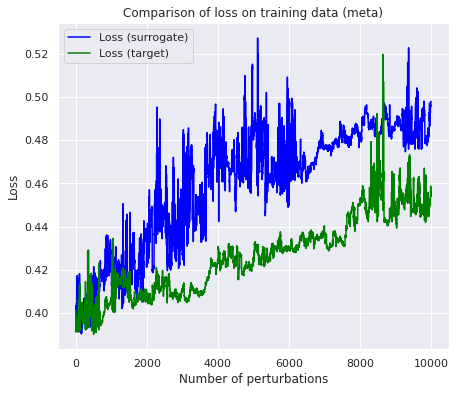

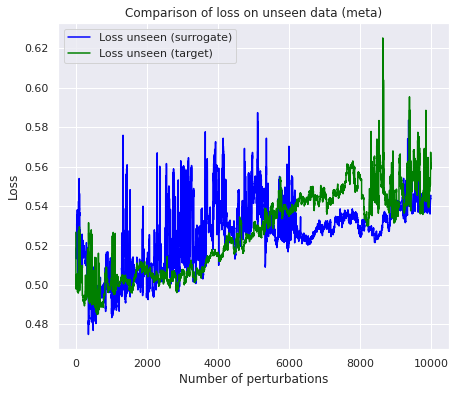

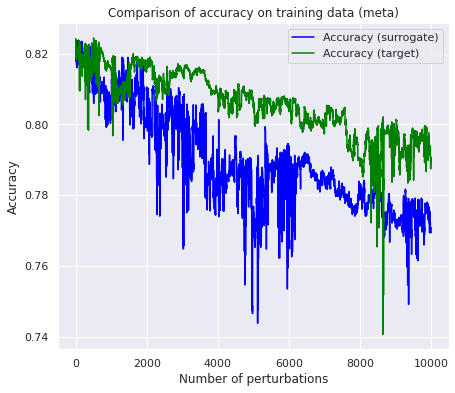

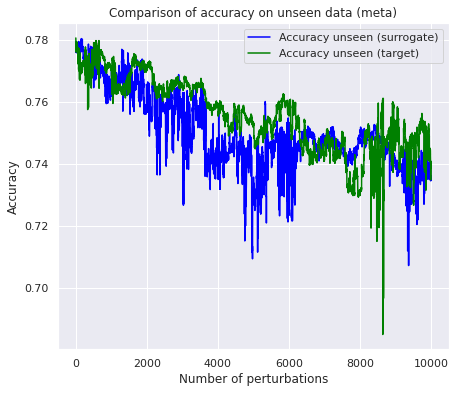

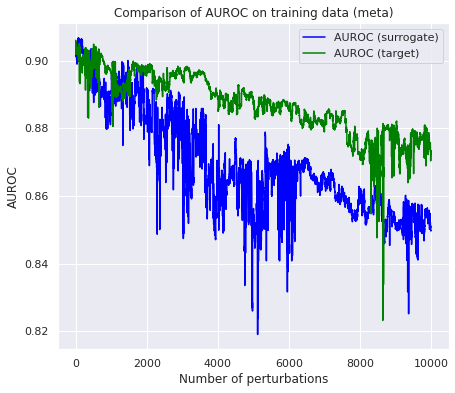

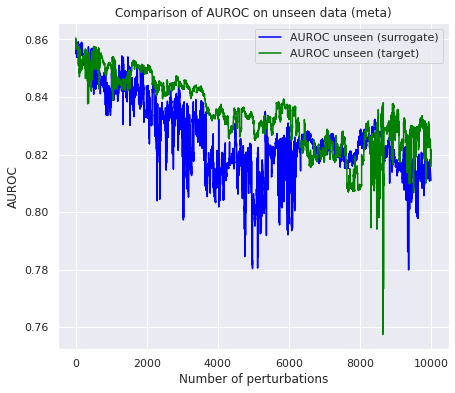

In [14]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Accuracy unseen (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Loss unseen (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Accuracy unseen (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)', 'Loss unseen (target)', 'AUROC including perturbed edges (surrogate)', 'AUROC excluding perturbed edges (surrogate)', 'AUROC unseen (surrogate)', 'AUROC including perturbed edges (target)', 'AUROC excluding perturbed edges (target)', 'AUROC unseen (target)']
perturbations_reset

# Figure specifications
sns.set_theme()
figsize = (7, 6)
print('File name: ', filename)

# Loss on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-' + filename + '.png')
plt.show()

# Loss on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (surrogate)', color = 'blue').set_title('Comparison of loss on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss unseen (surrogate)', 'Loss unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-unseen-' + filename + '.png')
plt.show()

# Accuracy on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/accuracy-' + filename + '.png')
plt.show()

# Accuracy on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (surrogate)', color = 'blue').set_title('Comparison of accuracy on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy unseen (surrogate)', 'Accuracy unseen (target)'])
if save_results: 
    fig.savefig('plots/' + dataset + '/accuracy-unseen-' + filename + '.png')
plt.show()

# AUROC on training data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of AUROC on training data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC (surrogate)', 'AUROC (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-' + filename + '.png')
plt.show()

# AUROC on unseen data plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (surrogate)', color = 'blue').set_title('Comparison of AUROC on unseen data ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'AUROC unseen (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('AUROC')
plt.legend(labels = ['AUROC unseen (surrogate)', 'AUROC unseen (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/AUROC-unseen-' + filename + '.png')
plt.show()